## PPI YEAST ANALYSIS

### Load annotations

In [1]:
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd

In [7]:
annots_file_yeast = "data/ppi/4932.annotations.tsv"
annots_yeast = open(annots_file_yeast, 'r')

annots_dict = {x[0]: x[1:] for l in annots_yeast.readlines() if (x := l.strip().split('\t')) is not None} 

In [8]:
len(annots_dict)

5468

In [9]:
goClasses = {}

for prot, classes in annots_dict.items():
    for cls in classes:
        if cls in goClasses:
            goClasses[cls] +=1
        else:
            goClasses[cls] = 1

max_value = max(goClasses, key=goClasses.get)
print(max_value, goClasses[max_value])


GO:0005575 5224


GO:0005575 5224


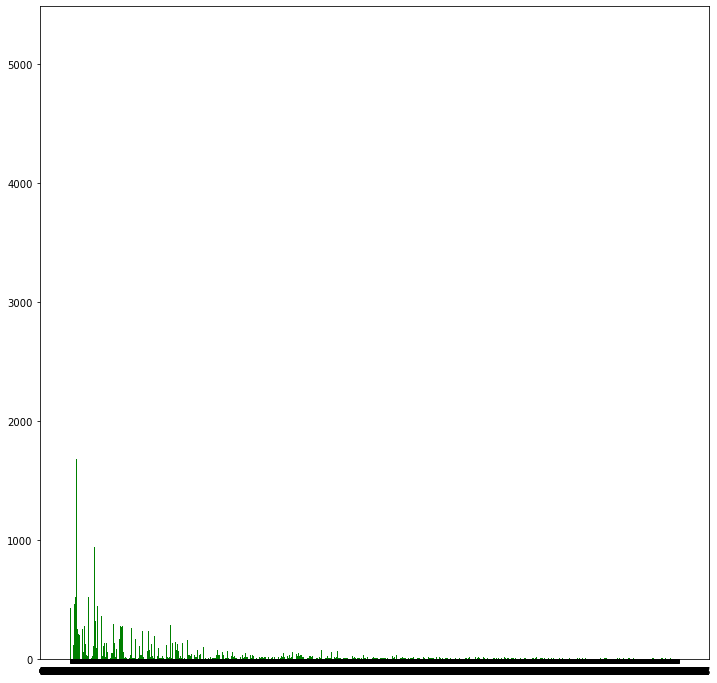

In [10]:
#del goClasses["GO:0005575"]
max_value = max(goClasses, key=goClasses.get)
print(max_value, goClasses[max_value])

plt.figure(figsize=(12,12))
plt.bar(list(goClasses.keys()), goClasses.values(), color='g')
plt.show()

### Look for proteins with only _binding_ annotation

In [11]:
goClasses["GO:0005488"]

1795

In [15]:
for prot, classes in annots_dict.items():
    if len(classes) == 1:
        print(len(classes))



### Load Interactions

In [47]:
def loadInteractionsFile(file_name):
    data_frame_train = pd.read_pickle(file_name)

    degrees = {}
    pos = 0
    neg = 0

    for row in data_frame_train.itertuples():
        p1, p2 = row.interactions
        label = row.labels

        if label == 1:
            pos += 1
            if p1 in degrees:
                degrees[p1] += 1
            else:
                degrees[p1] = 1
            if p2 in degrees:
                degrees[p2] += 1
            else:
                degrees[p2] = 1
        else:
            neg +=1

    total = pos + neg
    print(f"Positives: {pos} ({pos/total}%), Negatives: {neg} ({neg/total}%), Total: {pos + neg}, Pos/Neg: {pos/neg}")
    return degrees

In [49]:
train_interactions_file = "data/ppi/4932.train_interactions.pkl"
degreesTrain = loadInteractionsFile(train_interactions_file)

val_interactions_file = "data/ppi/4932.valid_interactions.pkl"
degreesVal = loadInteractionsFile(val_interactions_file)

test_interactions_file = "data/ppi/4932.test_interactions.pkl"
degreesTest = loadInteractionsFile(test_interactions_file)

max_value_train = max(degreesTrain, key=degreesTrain.get)
print(max_value_train, degreesTrain[max_value_train])

max_value_val = max(degreesVal, key=degreesVal.get)
print(max_value_val, degreesVal[max_value_val])

max_value_test = max(degreesTest, key=degreesTest.get)
print(max_value_test, degreesTest[max_value_test])

#print(sorted(annots_dict[max_value_train]))
#print(sorted(annots_dict[max_value_val]))
#print(sorted(annots_dict[max_value_test]))

Positives: 45407 (0.1551691732535053%), Negatives: 247222 (0.8448308267464947%), Total: 292629, Pos/Neg: 0.18366892914061048
Positives: 2837 (0.15132280776616172%), Negatives: 15911 (0.8486771922338383%), Total: 18748, Pos/Neg: 0.17830431776758218
Positives: 4255 (0.14258905532656413%), Negatives: 25586 (0.8574109446734359%), Total: 29841, Pos/Neg: 0.16630188384272648
P15646 215
P26783 63
P33201 72


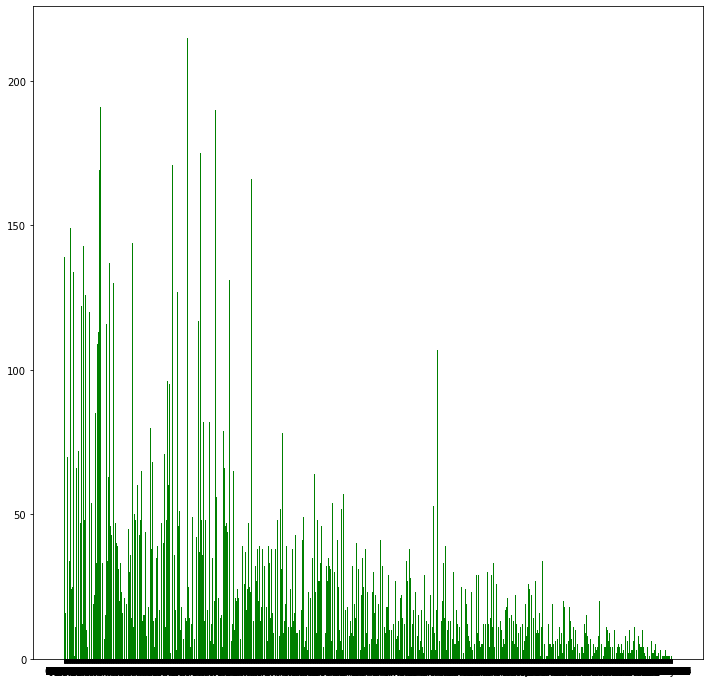

In [29]:
plt.figure(figsize=(12,12))
plt.bar(list(degrees.keys()), degrees.values(), color='g')
plt.show()

## IC

In [1]:
import sys
sys.path.append("../../../")

from mowl.datasets.base import PathDataset
from org.mowl.IC import IC
import pandas as pd

#JPype
from jpype import JObject
from java.util import HashMap
from java.util import ArrayList

def getAnnotsDict(training_prots):
    data_file = "data/ppi/4932.annotations.tsv"

    with open(data_file, 'r') as f:
        rows = [line.strip('\n').split('\t') for line in f.readlines()]

        annots_dict = HashMap()

        for i, row  in enumerate(rows):
            prot_id = row[0]

            if prot_id in training_prots:
                if not prot_id in annots_dict:
                    annots_dict.put(prot_id, ArrayList())

            for go_id in row[1:]:

                if prot_id in training_prots:
                    prot_annots = annots_dict[prot_id]
                    prot_annots.add(go_id)
                    annots_dict.put(prot_id, prot_annots)

    return annots_dict

In [2]:


ds = PathDataset("data/ppi/go.owl", None, None)

train_df = pd.read_pickle("data/ppi/4932.train_interactions.pkl")

#For computing IC
training_prots = set()
for row in train_df.itertuples():
    p1, p2 = row.interactions
    training_prots.add(p1)
    training_prots.add(p2)

annots_dict = getAnnotsDict(training_prots)
ics = IC.computeIC(ds.ontology, annots_dict)
ics = {format(str(k)): v for k, v in ics.items()}

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/ibex/scratch/zhapacfp/mowl/gateway/build/distributions/gateway/lib/slf4j-simple-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/ibex/scratch/zhapacfp/mowl/gateway/build/distributions/gateway/lib/slf4j-log4j12-1.7.3.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.SimpleLoggerFactory]
[main] INFO slib.graph.io.loader.rdf.RDFLoader - -------------------------------------
[main] INFO slib.graph.io.loader.rdf.RDFLoader -  RDF Loader
[main] INFO slib.graph.io.loader.rdf.RDFLoader - -------------------------------------
[main] INFO slib.graph.io.loader.rdf.RDFLoader - Populate graph http://graph/ from /tmp/tmp5525229912619046909.owl
[main] INFO slib.graph.io.loader.rdf.RDFLoader - Parser loaded for: RDF/XML (mimeTypes=application/rdf+xml, app

In [3]:
sorted_ic = dict(sorted(ics.items(),key= lambda x:x[1]))

In [4]:
list_ic = list(sorted_ic.items())

In [5]:
list_ic[:10]

[('http://purl.obolibrary.org/obo/GO_0008150', -0.0),
 ('http://purl.obolibrary.org/obo/GO_0003674', 0.05521568892317033),
 ('http://purl.obolibrary.org/obo/GO_0009987', 0.08487088952751531),
 ('http://purl.obolibrary.org/obo/GO_0003824', 0.0907271860171759),
 ('http://purl.obolibrary.org/obo/GO_0065007', 0.11286035326522934),
 ('http://purl.obolibrary.org/obo/GO_0050789', 0.125816040503003),
 ('http://purl.obolibrary.org/obo/GO_0050794', 0.15391080391791814),
 ('http://purl.obolibrary.org/obo/GO_0008152', 0.16888522194864478),
 ('http://purl.obolibrary.org/obo/GO_0005575', 0.17241419339179986),
 ('http://graph/GO:0005575', 0.1729724929830054)]

In [6]:
ics["http://purl.obolibrary.org/obo/GO_0005488"]

0.2644125690472817

In [7]:
list_ic[-10:]

[('http://purl.obolibrary.org/obo/GO_0140040', 1.0),
 ('http://purl.obolibrary.org/obo/GO_0140043', 1.0),
 ('http://purl.obolibrary.org/obo/GO_0140042', 1.0),
 ('http://purl.obolibrary.org/obo/GO_0140045', 1.0),
 ('http://purl.obolibrary.org/obo/GO_0140037', 1.0),
 ('http://purl.obolibrary.org/obo/GO_0140039', 1.0),
 ('http://purl.obolibrary.org/obo/GO_0140032', 1.0),
 ('http://purl.obolibrary.org/obo/GO_0140031', 1.0),
 ('http://purl.obolibrary.org/obo/GO_0140033', 1.0),
 ('http://purl.obolibrary.org/obo/GO_0140036', 1.0)]